In [5]:
! pip install -q kaggle|

/bin/bash: -c: line 2: syntax error: unexpected end of file


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"negarmansouri96","key":"dff6cfe0d2006e749b7c718a13c89eef"}'}

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d engraqeel/iot23preprocesseddata

Dataset URL: https://www.kaggle.com/datasets/engraqeel/iot23preprocesseddata
License(s): unknown
iot23preprocesseddata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile
import os
import pandas as pd
import re

zip_file_path = "/content/iot23preprocesseddata.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [10]:
folder_path = '/content/extracted_files'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]


combined_df = pd.DataFrame()


for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)



print("number of categories:", len(set(combined_df['label'])))
print("categories:", set(combined_df['label']))
print("category count:", combined_df['label'].value_counts())

<ipython-input-10-017e86722e1f>:11: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


number of categories: 13
categories: {'C&C-Torii', 'Okiru', 'C&C', 'Okiru-Attack', 'Attack', 'FileDownload', 'C&C-HeartBeat-FileDownload', 'C&C-Mirai', 'Benign', 'C&C-HeartBeat', 'PartOfAHorizontalPortScan', 'C&C-FileDownload', 'DDoS'}
category count: label
PartOfAHorizontalPortScan     3389036
Okiru                         1313012
Benign                         688812
DDoS                           638506
C&C                             15286
C&C-HeartBeat                    1332
Attack                            538
C&C-FileDownload                   46
C&C-Torii                          30
FileDownload                       13
C&C-HeartBeat-FileDownload          8
Okiru-Attack                        3
C&C-Mirai                           1
Name: count, dtype: int64


In [11]:
class_mapping = {
    'DDoS': 'DDoS',
    'Benign': 'Benign',
    'PartOfAHorizontalPortScan': 'PortScan',
    'Okiru': 'Okiru',
    'C&C-HeartBeat': 'C&C',
    'C&C': 'C&C',
    'C&C-Mirai': 'C&C',
    'C&C-Torii': 'C&C',
    'C&C-PartOfAHorizontalPortScan': 'C&C',
    'C&C-FileDownload': 'C&C',
    'C&C-HeartBeat-FileDownload': 'C&C',

    'Okiru-Attack': 'Okiru',
}


combined_df['merged_label'] = combined_df['label'].map(class_mapping)


combined_df = combined_df.dropna(subset=['merged_label'])


merged_category_counts = combined_df['merged_label'].value_counts()


print("Counts of merged categories:")
print(merged_category_counts)


Counts of merged categories:
merged_label
PortScan    3389036
Okiru       1313015
Benign       688812
DDoS         638506
C&C           16703
Name: count, dtype: int64


In [12]:
print(combined_df['merged_label'].isnull().sum())


0


In [13]:
from sklearn.utils import resample


df_benign = combined_df[combined_df['merged_label'] == 'Benign']
df_ddos = combined_df[combined_df['merged_label'] == 'DDoS']
df_portscan = combined_df[combined_df['merged_label'] == 'PortScan']
df_cnc = combined_df[combined_df['merged_label'] == 'C&C']
df_okiru = combined_df[combined_df['merged_label'] == 'Okiru']


min_samples = 10000
df_ddos_downsampled = resample(df_ddos, replace=False, n_samples=min_samples, random_state=42)
df_portscan_downsampled = resample(df_portscan, replace=False, n_samples=min_samples, random_state=42)
df_cnc_downsampled = resample(df_cnc, replace=False, n_samples=min_samples, random_state=42)
df_okiru_downsampled = resample(df_okiru, replace=False, n_samples=min_samples, random_state=42)
df_benign_downsampled = resample(df_benign, replace=False, n_samples=min_samples, random_state=42)


balanced_df = pd.concat([ df_benign_downsampled, df_ddos_downsampled, df_portscan_downsampled,
                         df_cnc_downsampled, df_okiru_downsampled])


In [14]:
merged_category_counts = balanced_df['merged_label'].value_counts()


print("Counts of merged categories:")
print(merged_category_counts)

Counts of merged categories:
merged_label
Benign      10000
DDoS        10000
PortScan    10000
C&C         10000
Okiru       10000
Name: count, dtype: int64


In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

import pandas as pd


features = balanced_df.drop(columns=['label', 'merged_label'])
labels = balanced_df['merged_label']
categorical_columns = features.select_dtypes(include=['object']).columns
label_encoders = {}


for column in categorical_columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column].astype(str))
    label_encoders[column] = le

features = features.dropna(axis=1)


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


selected_features_df = pd.DataFrame(scaled_features)
final_data = pd.concat([selected_features_df, pd.DataFrame(encoded_labels, columns=['encoded_label'])], axis=1)

# Results
final_data.head(), label_mapping


(          0         1         2         3         4         5         6  \
 0  0.407495 -0.093351 -0.777102 -0.616974  0.614198 -1.618821 -0.899799   
 1 -0.206111 -0.093441 -1.116237 -0.616974  0.032605  0.530444 -0.899799   
 2 -0.596082 -0.093498 -0.078185 -0.616974  0.184787  2.211129 -0.899799   
 3 -1.165787 -0.093581  0.338270 -0.616974  0.404230 -1.548689 -0.899799   
 4  0.190360 -0.093383  0.136243 -0.616974 -0.118175  1.681850 -0.899799   
 
           7         8         9  ...       12   13   14        15        16  \
 0 -0.063595 -0.150819 -0.514739  ...  0.40332  0.0  0.0 -0.013025  0.020751   
 1 -0.063595 -0.150819  1.885803  ...  0.40332  0.0  0.0 -0.013025  0.020751   
 2 -0.063595 -0.150819 -0.514739  ...  0.40332  0.0  0.0 -0.013025  0.020751   
 3 -0.063595 -0.150819 -0.514739  ...  0.40332  0.0  0.0 -0.013025  0.020751   
 4 -0.063595 -0.150819 -0.514739  ...  0.40332  0.0  0.0 -0.013025  0.020751   
 
          17        18        19        20  encoded_label  


In [16]:
final_data.shape

(50000, 22)

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training set: X_train: (30000, 21), y_train: (30000,)
Validation set: X_val: (15000, 21), y_val: (15000,)
Test set: X_test: (5000, 21), y_test: (5000,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,141 (12.27 KB)

 Trainable params: 3,141 (12.27 KB)

 Non-trainable params: 0 (0.00 B)

Model parameter count: 3141

Epoch 1/28


Validation: 100%|██████████| 468/468 [00:05<00:00, 91.52batch/s, val_loss=0.2506, val_accuracy=0.9251] 



Epoch 2/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.51batch/s, loss=0.2513, accuracy=0.9261] 



Epoch 3/28


Training: 100%|██████████| 937/937 [00:05<00:00, 161.91batch/s, loss=0.1763, accuracy=0.9486]



Epoch 4/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.57batch/s, loss=0.1457, accuracy=0.9571] 



Epoch 5/28


Training: 100%|██████████| 937/937 [00:05<00:00, 168.48batch/s, loss=0.1287, accuracy=0.9644]



Epoch 6/28


Validation: 100%|██████████| 468/468 [00:02<00:00, 222.16batch/s, val_loss=0.1753, val_accuracy=0.9823]



Epoch 7/28


Training: 100%|██████████| 937/937 [00:05<00:00, 163.08batch/s, loss=0.1071, accuracy=0.9697]



Epoch 8/28


Training: 100%|██████████| 937/937 [00:06<00:00, 139.87batch/s, loss=0.0991, accuracy=0.9710]



Epoch 9/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.56batch/s, loss=0.0943, accuracy=0.9718] 



Epoch 10/28


Training: 100%|██████████| 937/937 [00:05<00:00, 160.04batch/s, loss=0.0858, accuracy=0.9743]



Epoch 11/28


Validation: 100%|██████████| 468/468 [00:05<00:00, 91.58batch/s, val_loss=0.2111, val_accuracy=0.9846] 



Epoch 12/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.56batch/s, loss=0.0774, accuracy=0.9765] 



Epoch 13/28


Training: 100%|██████████| 937/937 [00:06<00:00, 143.68batch/s, loss=0.0755, accuracy=0.9775]



Epoch 14/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.52batch/s, loss=0.0724, accuracy=0.9784] 



Epoch 15/28


Training: 100%|██████████| 937/937 [00:06<00:00, 150.71batch/s, loss=0.0671, accuracy=0.9794]



Epoch 16/28


Validation: 100%|██████████| 468/468 [00:02<00:00, 183.13batch/s, val_loss=0.2286, val_accuracy=0.9863]



Epoch 17/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.53batch/s, loss=0.0631, accuracy=0.9806] 



Epoch 18/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.59batch/s, loss=0.0634, accuracy=0.9810] 



Epoch 19/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.54batch/s, loss=0.0601, accuracy=0.9827] 



Epoch 20/28


Training: 100%|██████████| 937/937 [00:06<00:00, 137.41batch/s, loss=0.0555, accuracy=0.9844]



Epoch 21/28


Validation: 100%|██████████| 468/468 [00:02<00:00, 183.66batch/s, val_loss=0.2949, val_accuracy=0.9942]



Epoch 22/28


Training: 100%|██████████| 937/937 [00:07<00:00, 133.41batch/s, loss=0.0528, accuracy=0.9849]



Epoch 23/28


Training: 100%|██████████| 937/937 [00:06<00:00, 136.36batch/s, loss=0.0509, accuracy=0.9854]



Epoch 24/28


Training: 100%|██████████| 937/937 [00:06<00:00, 153.31batch/s, loss=0.0523, accuracy=0.9857]



Epoch 25/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.52batch/s, loss=0.0460, accuracy=0.9867] 



Epoch 26/28


Validation: 100%|██████████| 468/468 [00:02<00:00, 210.68batch/s, val_loss=0.3145, val_accuracy=0.9965]



Epoch 27/28


Training: 100%|██████████| 937/937 [00:10<00:00, 91.58batch/s, loss=0.0471, accuracy=0.9868] 



Epoch 28/28


Validation: 100%|██████████| 468/468 [00:02<00:00, 183.52batch/s, val_loss=0.3165, val_accuracy=0.9967]

 43/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


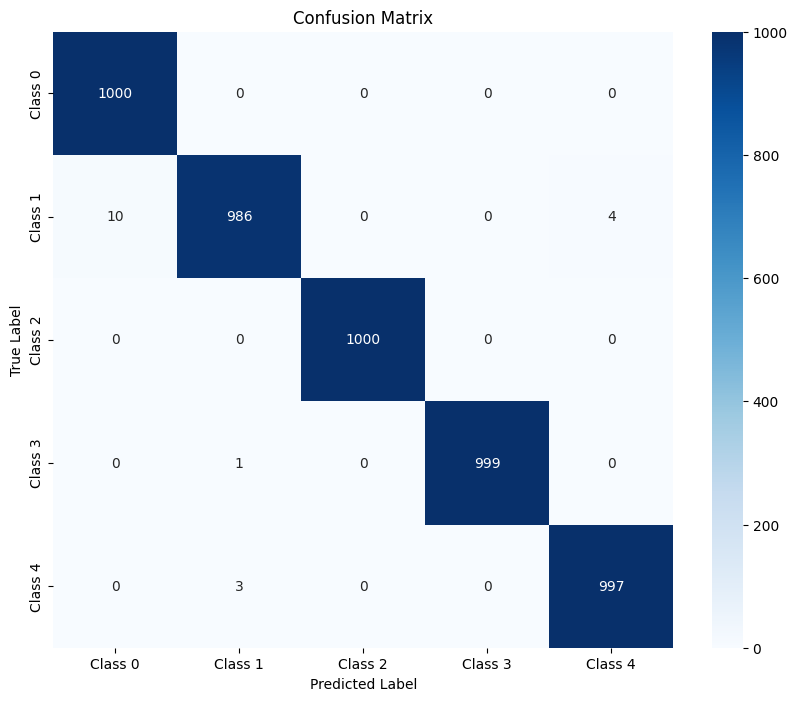


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00      1000
     Class 1       1.00      0.99      0.99      1000
     Class 2       1.00      1.00      1.00      1000
     Class 3       1.00      1.00      1.00      1000
     Class 4       1.00      1.00      1.00      1000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000


Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


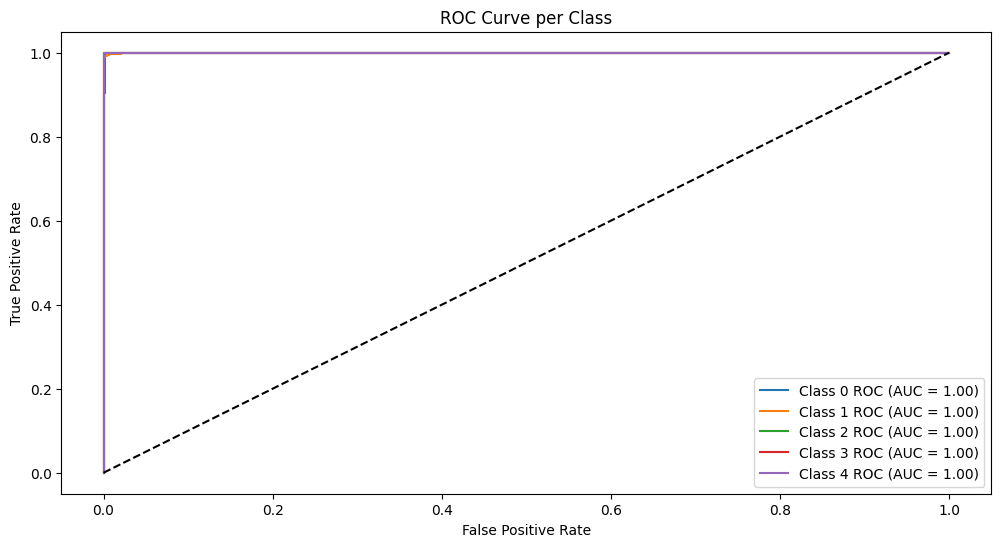

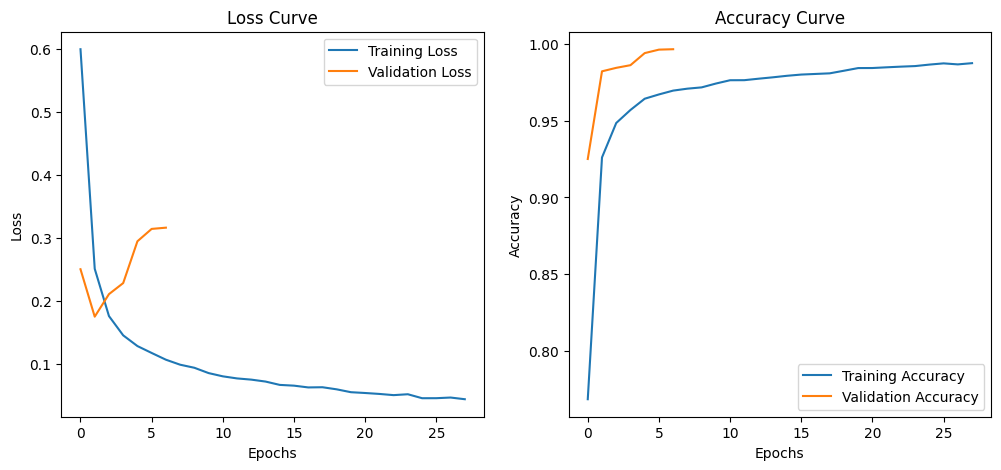

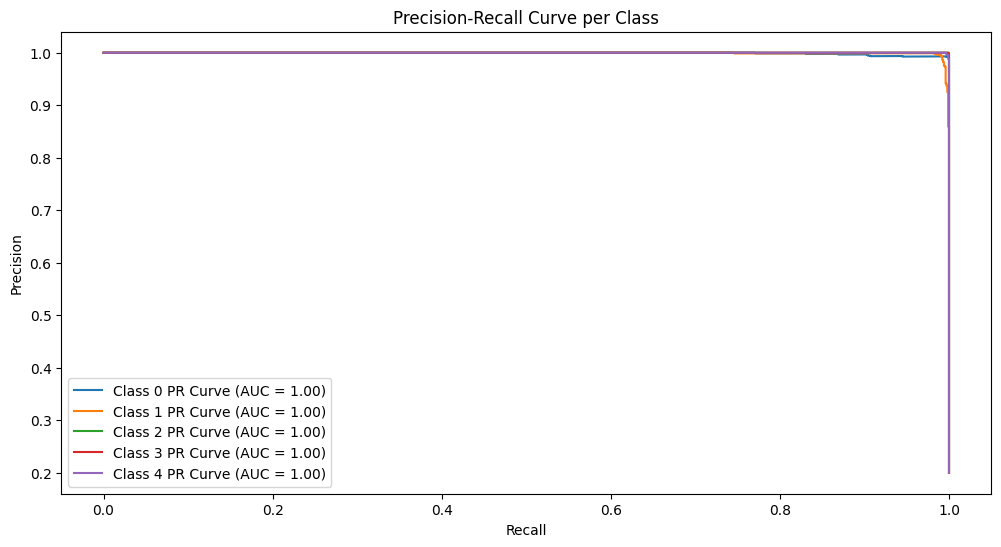

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score)
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Using GPU:", tf.config.list_physical_devices('GPU'))

X = final_data.drop(columns=['encoded_label'])
y = final_data['encoded_label']
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Verify shapes
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Model definition for multi-class classification
def create_dnn_model():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),  # Dropout for regularization
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer for the number of classes
    ])
    return model

# Initialize the model
model = create_dnn_model()
model.summary()  # Print model architecture
print(f"Model parameter count: {model.count_params()}")

# Optimizer and Loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Create data pipelines with prefetch
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Training and validation steps using GradientTape
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(x_batch, training=True)
        loss = loss_fn(y_batch, logits)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    acc = tf.keras.metrics.sparse_categorical_accuracy(y_batch, logits)
    return loss, tf.reduce_mean(acc)

@tf.function
def validate_step(x_batch, y_batch):
    logits = model(x_batch, training=False)
    loss = loss_fn(y_batch, logits)
    acc = tf.keras.metrics.sparse_categorical_accuracy(y_batch, logits)
    return loss, tf.reduce_mean(acc)

# Custom training loop with offloaded validation
epochs = 28
steps_per_epoch = len(X_train) // batch_size
val_steps = len(X_val) // batch_size

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    epoch_loss = []
    epoch_acc = []

    # Training progress bar
    with tqdm(total=steps_per_epoch, desc="Training", unit="batch") as pbar:
        for step, (x_batch, y_batch) in enumerate(train_dataset.take(steps_per_epoch)):
            loss, acc = train_step(x_batch, y_batch)
            epoch_loss.append(loss.numpy())
            epoch_acc.append(acc.numpy())
            pbar.set_postfix({"loss": f"{np.mean(epoch_loss):.4f}", "accuracy": f"{np.mean(epoch_acc):.4f}"})
            pbar.update(1)

    # Log training metrics
    history['loss'].append(np.mean(epoch_loss))
    history['accuracy'].append(np.mean(epoch_acc))

    # Offload validation
    if epoch % 5 == 0 or epoch == epochs - 1:  # Perform validation every 5 epochs
        val_loss = []
        val_acc = []
        with tqdm(total=val_steps, desc="Validation", unit="batch") as pbar:
            for step, (x_batch, y_batch) in enumerate(val_dataset.take(val_steps)):
                loss, acc = validate_step(x_batch, y_batch)
                val_loss.append(loss.numpy())
                val_acc.append(acc.numpy())
                pbar.set_postfix({"val_loss": f"{np.mean(val_loss):.4f}", "val_accuracy": f"{np.mean(val_acc):.4f}"})
                pbar.update(1)
        # Log validation metrics
        history['val_loss'].append(np.mean(val_loss))
        history['val_accuracy'].append(np.mean(val_acc))

# Evaluation on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# # Confusion Matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# print("\nConfusion Matrix:\n", conf_matrix)

import seaborn as sns

# Confusion Matrix as Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"Class {i}" for i in range(len(np.unique(y)))], yticklabels=[f"Class {i}" for i in range(len(np.unique(y)))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Classification Report
class_report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(len(np.unique(y)))])
print("\nClassification Report:\n", class_report)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# ROC and AUC Curves for each class
plt.figure(figsize=(12, 6))
for i in range(len(np.unique(y))):  # For each class
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.show()

# Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
if history['val_loss']:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
if history['val_accuracy']:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Precision-Recall Curve for each class
plt.figure(figsize=(12, 6))
for i in range(len(np.unique(y))):
    precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_pred_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} PR Curve (AUC = {auc(recall, precision):.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend()
plt.show()
